# 3D House project

This project consists of plotting an interactive 3D Surface Graph of a house, based on the address provided. The region covered is the region of Flanders (Belgium).

The data are *Lidar* data. The region is divided into 43 rasters. Each raster is in the format **.tif** . This program will select the correct raster after getting from an API the geospatial coordinates corresponding to the address of the house.

## 1. Libraries

In [137]:
import geopandas as gpd
from shapely.geometry import Polygon

import rasterio # Tif files
import os
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
from plotly.graph_objs import *
from rasterio.plot import show
from rasterio.mask import mask

import requests
import json

## 2. Address and coordinates

In [138]:
street_name = input("Street name: ")

Street name:  Ooidonkdreef


In [139]:
house_number = int(input("House number: "))

House number:  9


In [140]:
post_code = int(input("Post code: "))

Post code:  9800


In [141]:
house_address = f'{street_name} {house_number} {post_code}' # Will be use for the title of the 3D plot later on

In [142]:
# Address request to the basisregisters Vlaanderen API

# HTTP request to the API
address = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch",
                      params={'postcode': post_code, 'straatnaam': street_name, 'huisnummer':house_number})

address = address.json() # Convert http request's response into json format

In [143]:
def get_coordinates(address):
    """
    Function that get the geospatial coordinates and separate the latitude and longitude
    in two different lists (lat, lon).
    """

    address = address['adresMatches'][0]
    
    norm = pd.json_normalize(address)
    norm = norm.loc[0,'adresseerbareObjecten']
    block_url = norm[0].get('detail')
    block_url
    
    # Second request
    address = requests.get(block_url)
    block_details = address.json()
    block_details
    
    building = block_details.get('gebouw')
    url_house = building.get('detail')
    
    # Third request
    house = requests.get(url_house)
    house_details = house.json()


    df = pd.json_normalize(house_details) # Convert the json format into a Pandas DataFrame
    
    house_coordinates = df.loc[0,'geometriePolygoon.polygon.coordinates']
    lat_lon = []

    # Write geometry coordinates to a list
    for list in house_coordinates:
        for sublist in list:
            for coordinates in sublist:
                print(coordinates, end='\n')
                lat_lon.append(coordinates)

    lat = []
    lon = []

    for i, coords in enumerate(lat_lon):
        if i % 2 == 0:
            lat.append(coords)
        else:
            lon.append(coords)

    return lat, lon

In [144]:
lat, lon = get_coordinates(address)

94913.04195717722
188201.4174766913
94915.1092851758
188205.16058069468
94914.6943731755
188209.0231086947
94910.79075717181
188212.25875669718
94910.59094917774
188212.2346927002
94909.6075251773
188213.1533486992
94906.99152517319
188215.5971246995
94906.21283717453
188216.3245487027
94906.2694131732
188216.66758870333
94902.4038771689
188220.5536047034
94899.54998916388
188220.8439727053
94895.9340531677
188218.3685807027
94894.85853316635
188220.4919727035
94892.29066116363
188220.72870870307
94891.80176515877
188219.94733270258
94887.2797171548
188224.26752470806
94887.5025651604
188224.8248367086
94887.73386115581
188225.59162070975
94887.88758915663
188226.37766870856
94887.96221315861
188227.17510870844
94887.9569651559
188227.97606870905
94887.87184515595
188228.77242071182
94887.70781315863
188229.55642070994
94887.46640516073
188230.32006870955
94887.1500531584
188231.05587671325
94886.76195716113
188231.7564847134
94886.30595716089
188232.4149167128
94885.78653315455
188233

## 3. Creation of the polygon

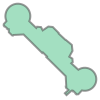

In [145]:
polygon_geometry = Polygon(zip(lat, lon)) # Geometry
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:31370', geometry=[polygon_geometry])

polygon_geometry

## 4. Selection of the raster

All the rasters are located in the local drive and separated in two distincts folders (/DSM and /DTM)

In [146]:
def get_raster_number(coordinates):
    """
    Function that select the correct raster based on the coordinates of the address.
    """
    
    df = pd.read_csv('Utils/rasters_lambert_coordinates.csv') # Load the csv file
    

    # Search for the correct raster
    raster = df[(df['Left'] < coordinates[0]) & (df['Right'] > coordinates[0])
       & ((df['Bottom'] < coordinates[1]) & (df['Top'] > coordinates[1]))]
    
    num_raster = raster['Raster'].item() # Raster number
    
    return num_raster

In [147]:
# Raster number
number = get_raster_number([lat[0],lon[0]])

path_DSM = f"/media/ms/Seagate Expansion Drive/BECODE/Rasters/DSM/DHMVIIDSMRAS1m_k{number}.tif"  
path_DTM = f"/media/ms/Seagate Expansion Drive/BECODE/Rasters/DTM/DHMVIIDTMRAS1m_k{number}.tif"
path_DSM

'/media/ms/Seagate Expansion Drive/BECODE/Rasters/DSM/DHMVIIDSMRAS1m_k21.tif'

## 5. Masking the DSM and DTM

In [148]:
def mask_rasters(DSM_path:str, DTM_path:str) -> str:
    
    # Open DTM and DSM rasters
    raster_DTM = rasterio.open(DTM_path)
    raster_DSM = rasterio.open(DSM_path)


    # Crop of the DTM raster based on the polygon geometry
    masked_DTM, masked_transform_DTM = mask(dataset=raster_DTM, shapes=polygon.geometry, crop=True, filled=False) 


    # Crop of the DSM raster based on the polygon geometry
    masked_DSM, masked_transform_DSM = mask(dataset=raster_DSM, shapes=polygon.geometry, crop=True, filled=False) 

    profile = raster_DTM.meta.copy()

    width = masked_DTM.shape[2]
    height = masked_DTM.shape[1]
    profile.update(drivers='GTiff', transform=masked_transform_DTM, height=height, width=width)

    print(profile)

    # Create a new file "masked_DSM.tif" and saving it into the local drive
    with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/masked_DSM.tif", 'w', **profile) as dst:
        dst.write(masked_DSM) 
    
    # Create a new file "masked_DTM.tif" and saving it into the local drive    
    with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/masked_DTM.tif", 'w', **profile) as dst:
        dst.write(masked_DTM) # Save the masked DTM

In [149]:
mask_rasters(path_DSM, path_DTM)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 61, 'height': 60, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 94870.0,
       0.0, -1.0, 188236.0), 'drivers': 'GTiff'}


## 6. Creation of the CHM (Canopy Height Model)

In [150]:
def Build_CHM():
    
    m_DTM = rasterio.open('masked_DTM.tif')
    m_DSM = rasterio.open('masked_DSM.tif')

    DSM_array = m_DSM.read(1)
    DTM_array = m_DTM.read(1)
    raster_CHM = DSM_array - DTM_array # Canopy Height Model (CHM) = (DSM - DTM)
    show(raster_CHM)

    print(profile)

     # Create a new file "CHM.tif" and save it into the local drive
    with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/CHM.tif", 'w', **profile) as dst:
        dst.write(raster_CHM, 1)

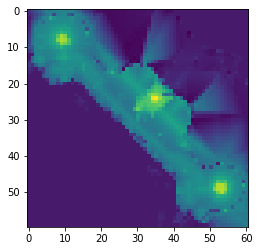

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 33, 'height': 46, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 94604.0,
       0.0, -1.0, 188572.0), 'drivers': 'GTiff'}


In [151]:
Build_CHM()

## 7. 3D Plot

The library used is **plotly**. The 3D Surface plot opens in the browser in a new tab.

In [152]:
def Plot_3d():
    CHM = rasterio.open('CHM.tif')
    CHM_array = CHM.read(1) # Convert the raster into a Numpy array

    #Plot
    fig = go.Figure(data=[go.Surface(z=CHM_array)]) # Create the figure from the CHM array
    fig.update_layout(title=f'3D Plot - {house_address}', title_x=0.5,
                    scene = dict(
                    xaxis_title='Distance (m)',
                    yaxis_title='Distance (m)',
                    zaxis_title='Height'),
                    font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="RebeccaPurple"))
    fig.update_scenes(yaxis_autorange="reversed")

    plot(fig) # Plot the house in new tab

In [153]:
Plot_3d()